# ASTRO 30400 - Galaxies

## Problem Set 6

### Exploring galaxy evolution and scaling relations

### Student : Dimitrios Tanoglidis

### Problem 2 - Model Tully-Fisher and baryonic Tully-Fisher relations (TFR and BTFR)

For galaxy model with all the included processes, construct the BTFR - i.e., the correlation of $M_{\rm g}+M_*$ and $V_{\rm 2.2}$, where $V_{\rm 2.2}$ is the rotation velocity at the $R_{\rm out}=2.2R_{\rm d}$. The radius $2.2R_{\rm d}$ can be computed using Mo et al. 1998 model that is already implemented (with adjustments to fit observed galaxies from HW5). The rotation velocity at $R_{\rm out}=2.2R_{\rm d}$ can be computed as a sum of contributions of baryons in the disk and dark matter in a spherical halo (see, e.g., S 11.1.2 in the Mo, van den Bosch & White book, as well as ex04 notebook): $$V_{c}^2(<R_{\rm out})=V_{\rm bar}^2(<R=R_{\rm out})+V^2_{\rm dm}(<R=R_{\rm out}).$$ Circular velocity profile of a thin exponential disk in closed form is (see eq. 11.30 in MvdBW book, although sign is wrong in their expression): $$V^2_{\rm bar}(<R)= 4\pi G\Sigma_0 R_d y^2 [I_0(y)K_0(y)-I_1(y)K_1(y)],$$ where $I_n$ and $K_n$ are the modified Bessel functions of the first and second kind, respectively, $R_d$ is the disk scale length, and $y=R/(2R_d)$. Recall that total mass of the exponential disk is $M_d=2\pi\Sigma_0 R_d^2$. Halo circular profile is $$V_c^2(<R)=V_{200}^2\frac{1}{x}\frac{\ln(1+cx)-cx/(1+cx)}{\ln(1+c)-c/(1+c)},$$ where $V_{200}=\sqrt{GM_{200}/R_{200}}$, $x=r/R_{200}$, and $c=c_{200}=R_{200}/r_s$ is halo concentration.


(a) Compare the model TFR (i.e., $M_*-V_{2.2}$ to the best fit relation for SDSS galaxies from the middle of Table 12 of Reyes et al. 2011. How well does the model match the observed relation? How does the model predictions depend on inclusion of outflows and assumptions about loading factor?

(b) Compare the model BTFR to the data in the recent compilation of Bradford et al. (2016). The data file is available in the usual place where I store data and scripts showing how to read the data is below. How well does the model match the observed relation? Discuss dependence on the wind modelling, as in a.

### Solution

### Part a) Comparison between model TFR and best fit relation of Reyes et al. 2011

In this problem we want to use our galaxy formation model to investigate if it can explain/ predict (actually, postdict) the Tully-Fisher relation  (TFR) and the Baryonic Tully Fisher Relation (BTFR), the relation (in our case) between the rotational velocity of the galaxy and the stellar mass (TFR) or the total baryonic mass (stellar mass + gas, BTFR).

What we actually need is to have for a grid of halo masses the corresponding stellar and gas masses as predicted from our galaxy formation model; from these quantities we can calculate the rotational velocity (see above; I will also discuss the details later) and thus plot it as a function of stellar or stellar + gas mass.

So, the first thing is to get for a grid of halo masses the corresponding stellar and gas masses. 
We will use the galaxy model as developed in notebooks.

Although it is probably not the most efficient thing to do, I start from the most basic model and then I add the most compicated models; for each one step I inherit the previous one to the subsequent class. 

I proceed to calculate stellar and gas masses (for $z = 0$) in three cases: no winds at all, a constant loading factor ($\eta = 1.0$) and also using the model of Muratov et. al. 2015. 

(P.S. I know that, probably, in the following I calculate more thing than those needed, like the relation in different redshifts, although I need the relation only for $z = 0$). I wanted to be sure that I will have a correct answer, so I kept the code as it was provided (HW05 solutions) although it is probably not the most efficient way to do it).

In [42]:
# setup notebook for inline figures
%matplotlib inline
import numpy as np
import code.galaxy_model as gm
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()

from colossus.cosmology import cosmology
# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)

In [43]:
# inherit class for this homework from the base model_galaxy class
# add the required functions to it

class gmodel_heating(gm.model_galaxy):
    def __init__(self, *args, **kwargs):
        super(gmodel_heating, self).__init__(*args, **kwargs)
        return

    def Mhot(self, z):
        mnl = self.cosmo.nonLinearMass(z)
        mhot = 1.e12 * self.cosmo.h * np.maximum(2., 1.e12/(3.*mnl/self.cosmo.h))
        return mhot
       
    def UV_cutoff(self, z):
        """
        approximation to the cutoff mass in Fig 3 of Okamoto, Gao & Theuns 2008
        the output is mass in /h Msun. 
        """
        dummy = np.zeros_like(z)
        dummy[z>9] = 1.e6
        dummy[z<=9] = 6.e9*np.exp(-0.63*z[z<9]) # expression from Nick
        return  1.0/(1.0+(2.**(2./3.)-1.)*(dummy/self.Mh)**2)**(1.5)

    def Mg_in(self, t):
        dummy = self.fbuni*self.fg_in(t)*self.eps_in(t)*self.dMhdt(self.Mh,t)
        return dummy

    def Ms_in(self, t):
        dummy = 0.0
        return dummy

    def fg_in(self,t):
        zd = self.cosmo.age(t, inverse=True)
        # here I implement soft suppression of baryon fraction, as seen in simulation (eq 2.2 in the notes)
        # results are qualitatively the same, but this function makes suppression a "softer" as a function of M
        return self.UV_cutoff(zd)
    
    def eps_in(self, t):
        zd = self.cosmo.age(t, inverse=True)
        epsin = 1.0
        if self.Mh >= self.Mhot(zd):
            epsin = 0.0
        return epsin
    

In [44]:
# inherit the model with UV and shock heating, add model for molecular gas
#
class gmodel_r50(gmodel_heating):

    def __init__(self, *args, **kwargs):

        # process kwargs and remove (via kwargs.pop extraction) those
        # keyword arguments that should not be passed to parent init
        if 'ac' in kwargs: # Flag to use adiabatic contraction correction
            self.ac = kwargs.pop('ac')
        else:
            self.ac = 'off'
        # factor in front of the MMW98 expression for Rd to set the fraction
        # of angular momentum lost during galaxy evolution
        if 'etar' in kwargs:
            self.etar = kwargs.pop('etar')
        else:
            self.etar = 1.0
                                                
        if 'verbose' in kwargs:
            self.verbose = kwargs['verbose']
        else:
            self.verbose = False
            
        if 'tausf' in kwargs:
            self.tausf = kwargs.pop('tausf')
        else:
            self.tausf = 2.0
            
        if 'sfrmodel' in kwargs:
            self.sfr_models = {'gaslinear': self.SFRgaslinear}
            try: 
                self.sfr_models[kwargs['sfrmodel']]
            except KeyError:
                print "unrecognized sfrmodel in model_galaxy.__init__:", sfrmodel
                print "available models:", self.sfr_models
                return
            self.sfrmodel = kwargs['sfrmodel']
        else:
            errmsg = 'to initialize gal object it is mandatory to supply sfrmodel!'
            raise Exception(errmsg)
            return
                
        # initialize everything in the parent class
        super(gmodel_r50, self).__init__(*args, **kwargs)
        
        return
    # redefine star formation function to use tau_sf that can be set on input
    def SFRgaslinear(self, t):
        return self.Mg/self.tausf

In [45]:
# inherit the model with UV and shock heating, add model for molecular gas
#
class gmodel_wind(gmodel_r50):

    def __init__(self, *args, **kwargs):

        self.wind_models = {'constload': self.constwindload, 
                            'Muratov15': self.Muratov15wind, 
                            'Muratov15mod': self.Muratov15modified}
        if 'windmodel' in kwargs: 
            try: 
                windmodel = kwargs.pop('windmodel')
                self.wind_models[windmodel]
            except KeyError:
                print "unrecognized windmodel in model_galaxy.__init__:", windmodel
                print "available models:", self.wind_models
                return
            self.windmodel = windmodel
            self.etawind = kwargs.pop('etawind')
               
        else:
            errmsg = 'to initialize gal object it is mandatory to supply windmodel!'
            raise Exception(errmsg)
            return
                                
        # initialize everything in the parent class
        super(gmodel_wind, self).__init__(*args, **kwargs)
        
        return

    def Muratov15wind(self):
        if self.Ms > 0.:
            return self.etawind*(self.Ms/1.e10)**(-0.35)
        else:
            return 0.

    def Muratov15modified(self):
        if self.Ms > 0.:
            return np.maximum(2.0,self.etawind*(self.Ms/1.e10)**(-0.35) - 1.6)
        else:
            return 0.
        
    def constwindload(self):
        return self.etawind # etawind = 0 means no wind

    def eps_out(self):
        return self.wind_models[self.windmodel]()

In [46]:
def compute_mass_grid(gmodel = None, Nz=81, Nm=60, Z_IGM=2.e-5, 
                      sfrmodel='gaslinear', tausf=1.0, windmodel='nowind', 
                      ac='off', etawind=1.0, cosmo=None):
    # grid of redshifts and halo masses
    zg = np.linspace(30., 0., Nz)
    lzg1 = np.log10(1.0+zg)
    t_output = cosmo.age(zg)
    
    lMh = np.linspace(5.0, 8., Nm)
    Mh  = np.power(10, lMh)

    # arrays to hold evolutionary grids of halo mass, gas mass, stellar mass and metal mass
    Mhout  = np.zeros((Nm,Nz)); Mgout  = np.zeros((Nm,Nz))
    Msout  = np.zeros((Nm,Nz)); MZout  = np.zeros((Nm,Nz))
    #evolve a grid of halo masses
    print("evolving mass grid...")
    for j, Mhd in enumerate(Mh):
        # instantiate a model galaxy with a given halo mass at the initial time
        g = gmodel(t = t_output[0], Mh = Mhd, Mg = None, Ms = None, MZ = None, Z_IGM = Z_IGM, 
                           sfrmodel = sfrmodel, tausf=tausf, windmodel = windmodel, ac=ac, etawind=etawind, cosmo = cosmo, verbose = False)
        # initial values of masses
        y0 = np.array([g.Mh, g.Mg, g.Ms, g.MZ])
        # solve the system of ODEs
        Mout = odeint(g.evolve, y0, t_output, rtol = 1.e-5, mxstep = 4000)
        # split Mout into arrays for specific masses with more intuitive names for convenience
        Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
        Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
        for i, td in enumerate(t_output):
            ge = gmodel(t = td, Mh = Mhout[j,i], Mg = Mgout[j,i], Ms = Msout[j,i], MZ = MZout[j,i], 
                                        sfrmodel = sfrmodel, tausf=tausf, windmodel = windmodel, etawind=etawind, ac=ac, cosmo = cosmo)
        Mhout[j,:] = Mout[:,0]; Mgout[j,:] = Mout[:,1]
        Msout[j,:] = Mout[:,2]; MZout[j,:] = Mout[:,3]
    print("done.")
    # 
    # prepare 2D splines for interpolation
    #
    Mmin = 1.e-10 # prevent zeros in case no SF occurred
    rmin = 1.e-10
    lMhi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mhout)), bounds_error=True, kind='cubic')
    lMgi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Mgout)), bounds_error=True, kind='cubic')
    lMsi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,Msout)), bounds_error=True, kind='cubic')
    lMZi  = interp2d(lzg1, lMh, np.log10(np.maximum(Mmin,MZout)), bounds_error=True, kind='cubic')
    return lMhi, lMgi, lMsi, lMZi

In [47]:
from colossus.cosmology import cosmology

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)    

sfrmodel = "gaslinear"  # another implemented option is gaslinear: SFR=Mgas/tau
from scipy.interpolate import interp2d

# no outflows
lMhinw, lMginw, lMsinw, lMZinw = compute_mass_grid(gmodel = gmodel_wind, Nz=81, Nm=60, Z_IGM=2.e-5, 
                                                   sfrmodel='gaslinear', tausf=2.0, 
                                                   windmodel='constload', etawind=0.0, 
                                                   ac='off',  cosmo=cosmo)
# constant mass loading factor = 1.0
lMhiw1, lMgiw1, lMsiw1, lMZiw1 = compute_mass_grid(gmodel = gmodel_wind, Nz=81, Nm=60, Z_IGM=2.e-5, 
                                                   sfrmodel='gaslinear', tausf=2.0, 
                                                   windmodel='constload', etawind=1.0, 
                                                   ac='off',  cosmo=cosmo)

# Muratov et al. 2015 mass loading factor
lMhiMw, lMgiMw, lMsiMw, lMZiMw = compute_mass_grid(gmodel = gmodel_wind, Nz=81, Nm=60, Z_IGM=2.e-5, 
                                                   sfrmodel='gaslinear', tausf=2.0, 
                                                   windmodel='Muratov15', etawind=3.6, 
                                                   ac='off',  cosmo=cosmo)



evolving mass grid...
done.
evolving mass grid...
done.
evolving mass grid...
done.


Let's define halo masses and stellar and gas masses in the three cases now:

In [48]:
Nm = 60
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)
z = 0.0

#Halo mass, stellar mass and gas mass in the case of no outflows

MhalNO = 10.**lMhinw(np.log10(1.0+z),lMh)
MstelNO = 10.**lMsinw(np.log10(1.0+z),lMh)
MgasNO = 10.**lMginw(np.log10(1.0+z),lMh)

#Halo mass, stellar mass and gas mass in the case of constant mass loading factor, eta = 1

MhalCON = 10.**lMhiw1(np.log10(1.0+z),lMh)
MstelCON = 10.**lMsiw1(np.log10(1.0+z),lMh)
MgasCON = 10.**lMgiw1(np.log10(1.0+z),lMh)

#Halo mass, stellar mass and gas mass in the case of Muratov et al. loading factor

MhalMUR = 10.**lMhiMw(np.log10(1.0+z),lMh)
MstelMUR = 10.**lMsiMw(np.log10(1.0 + z),lMh)
MgasMUR = 10.**lMgiMw(np.log10(1.0 +z),lMh)


I confirmed that these reproduce the results of HW5.

Now, we have halo masses, stellar masses and gas masses. All we need now is to calculate the rotation velocity at $R_{out} = 2.2R_d$.

We will use results from HW03 and HW05.

We have three different models. In order to work more efficiently, I will create functions that get as inputs halo, stellar and gas masses and give the quantities we want -- ultimately the rotation velocity.

Let's start with the calculation of the disc length scale, $R_d$. I will calculate it, using the formula from HW05:

\begin{equation}
R_d = \frac{1.187}{1.678}\left(\frac{j_d}{m_d} \right)f_c^{-1/2}f_R \lambda R_{200}.
\end{equation}

The definitions of the quantities are given in HW05.

I will assume, as in problem set 5, that $ j_{d}/m_{d} = 1$, $\lambda = 0.045$ and I will calculate $f_{c}$, $f_{R}$, and thus $R_{d}$. In order to calculate the scale radius, we need as an input  the halo and stellar mass.


Actually, it is very easy (and more efficient) to use the same function in order to calculate the halo circular velocity, according to:

$$V_c^2(< R)=V_{200}^2\frac{1}{x}\frac{\ln(1+cx)-cx/(1+cx)}{\ln(1+c)-c/(1+c)},$$ where
$V_{200}=\sqrt{GM_{200}/R_{200}}$, $x=r/R_{200}$, and $c=c_{200}=R_{200}/r_s$ is halo concentration.


In [49]:
from colossus.halo.concentration import concentration
from colossus.cosmology import cosmology
from colossus.halo.mass_so import M_to_R
from colossus.halo.mass_defs import changeMassDefinition

# define a vector of cosmological parameters:    
my_cosmo = {'flat': True, 'H0': 70.0, 'Om0': 0.27, 'Ob0': 0.045714, 'sigma8': 0.82, 'ns': 0.96}
# set my_cosmo to be the current cosmology
cosmo = cosmology.setCosmology('my_cosmo', my_cosmo)



# Function that calculates the disc length scale  and square of velocity due to the spherical halo

def R_d_and_Vcir(Mvir, Mstell):
    """
    This function takes as input the halo mass and returns the disc length scale.
    We apply the formula you can see above
    """
    #define h and redshift values
    h = 0.7
    z = 0.0
    Mvir = Mvir*h
    cvir = concentration(Mvir, 'vir', z, model='diemer15')
    M200, R200, c200 = changeMassDefinition(Mvir, cvir, z, 'vir', '200c')
    #Calculation of fc, equation 23 in Mo, Mao, White
    c = c200
    md = Mstell/(M200/h)
    #calculation of f_c
    fc = 0.5*c*(1.-1./(1.+c)**2-2.*np.log(1.+c)/(1.+c))/(c/(1.+c)-np.log(1.+c))**2
    #assume j_d/m_d =1 
    jmlam = 0.045 # (j_d/m_d)*lambda
    #calculation of f_R
    fR = (jmlam/0.1)**(-0.06+2.71*md+0.0047/jmlam)*(1.-3.*md+5.2*md**2)*(1.-0.019*c+2.5e-4*c*c+0.52/c)
    # calculation of eta, the numerical factor in front of r_d - R_200 relation
    eta = (1.187/1.678)*jmlam*fR/np.sqrt(fc)
    # M_to_R takes mass in /h Msun and outputs R in /h kpc
    Radius = M_to_R(M200, z, '200c')
    #Calculation of R_d. We divide by h to have result in kpc
    R_d = eta*Radius/h
    #Now, lets calculate halo circular profile
    Gn = 6.674e-11 #Newton's constant in SI
    msun = 1.99e30 #Solarmass in kg 
    kpc = 3.086e19 #kpc in m
    #Square of V200
    V200sq = Gn*(M200/R200)*(msun/kpc) #square of speed in m^2/sec^2
    V200sq = V200sq/1e6 #square of speed in km^2/sec^2
    # x = 2.2R_d/R_200 = 2.2etaR_200/R_200 = 2.2 eta
    x = 2.2*eta
    #calculate the square of the circular velocity
    up = np.log(1.0 + c*x) - (c*x)/(1.0 + c*x)
    down = x*(np.log(1.0 + c) - c/(1.0 + c))
    Vcirqsq = V200sq*up/down
    # Returns R_d in kpc 
    return R_d, Vcirqsq
    
    
    



Now, let's calculate the (square of) the rotational velocity due to the baryons in the disk:

$$V^2_{\rm bar}(<R)= 4\pi G\Sigma_0 R_d y^2 [I_0(y)K_0(y)-I_1(y)K_1(y)],$$

where $I_n$ and $K_n$ are the modified Bessel functions of the first and second kind, respectively, $R_d$ is the disk scale length, and $y=R/(2R_d)$. We have that total mass of the exponential disk is $M_d=2\pi\Sigma_0 R_d^2$. Thus, the above can be re-written as:

\begin{equation}
V^2_{\rm  bar}(<R) = 2G\frac{M_d}{R_d}y^2 \left[I_0(y)K_0(y) - I_1(y)K_1(y) \right].
\end{equation}

$M_d$ is the total stellar + gas mass.

$y$ can be calculated: 

\begin{equation}
y = \frac{R}{2R_d} = \frac{R_{out}}{2R_d} = \frac{2.2R_d}{2R_d} = \frac{2.2}{2} = 1.1
\end{equation}

So, let's write a function that gets as inputs $R_d, M_{\rm stell}, M_{\rm gas}$ and returns the (square of) rotational velocity due to the baryons in the disc.

In [50]:
from scipy.special import kn, iv

# Function that calculates the square of circular velocity due to the baryons in the disk

def V_disk(R_d, Mstel, Mgas):
    """
    This function takes R_d, Mstel, Mgas and applies the above equation 
    in order to calculate the square of rotational velocity duo to the baryons in the disk of the  galaxy 
    in km^2/s^2
    """
    Gn = 6.674e-11 #Newton's constant in SI
    msun = 1.99e30 #Solarmass in kg 
    kpc = 3.086e19 #kpc in m
    #Define parameters /constants
    y = 1.1 #see above why y = 1.1
    Mdisk = Mstel + Mgas
    # calculate the factor with bessel functions and y^2 etc.... Call it Bessel factor
    besfactor = (y**2.0)*(kn(0,y)*iv(0,y)-kn(1,y)*iv(1,y))
    #Calculate square of velocity in SI
    Vsquare = 2.0*Gn*(Mdisk/R_d)*besfactor*(msun/kpc) #square of velocity in m^2/sec^2
    Vsquare = Vsquare/1e6     #square of velocity in km^2/sec^2
    return Vsquare 
    

Now, we have all we need in order to calculate $V_{2.2}$ for the tree cases mentioned above - no winds, winds with constant mass loading factor $\eta = 1$ and winds with loading facor according to the Muratov et. al. model


###### First case: No winds

In [51]:
#Calculate V_2.2 for the case where we have no outflow


RdNO, VsqhalNO = R_d_and_Vcir(MhalNO, MstelNO)

VdiscNO = V_disk(RdNO, MstelNO, MgasNO)

V22NO = np.sqrt(VsqhalNO + VdiscNO)

###### Second case:  Winds with constant loading factor $\eta =1$

In [52]:
#Calculate V_2.2 for the case where we have outflows with constant loading factor


RdCON, VsqhalCON = R_d_and_Vcir(MhalCON, MstelCON)

VdiscCON = V_disk(RdCON, MstelCON, MgasCON)

V22CON = np.sqrt(VsqhalCON + VdiscCON)

###### Third case: Winds with loading factor according to the model of Muratov et. al. 2015

In [53]:
#Calculate V_2.2 for the case where we have outflows with constant loading factor


RdMUR, VsqhalMUR = R_d_and_Vcir(MhalMUR, MstelMUR)

VdiscMUR = V_disk(RdMUR, MstelMUR, MgasMUR)

V22MUR = np.sqrt(VsqhalMUR + VdiscMUR)

In a while, I will plot the prediction of our galaxy model for the TFR relation. We want to compare this with the best fit model to the SDSS data, given in Reyes et. al. 2011.

The rotational velocity, according to the model is given by:

\begin{equation}
\log{V_{2.2}} = a + (-2.5 b)\times \left( \log M_\star - \log M_{\star, \rm  p} \right) \Rightarrow V_{2.2} = 10^a\times \left(\frac{M_\star}{M_{\star,p}} \right)^{-2.5b},
\end{equation}

where $a, b$ parameters and $M_{\star, \rm p}$ a pivot point. In our case:

\begin{equation}
a = 2.120, \qquad b = -0.115, \qquad M_{\star, \rm p} = 10^{10.102} \,  M_\odot
\end{equation}

from table 12 of Reyes et. al.

We implement this model to get the model velocity for the three cases mentioned above.

In [54]:
a = 2.120
b = -0.116
Mpivot = 10**10.102

#Reyes, model no winds

VreyesNO  = (10**a)*((MstelNO/Mpivot)**(-2.5*b))

#Reyes, model const winds

VreyesCON = (10**a)*((MstelCON/Mpivot)**(-2.5*b))

#Reyes, model Muratov et al

VreyesMUR = (10**a)*((MstelMUR/Mpivot)**(-2.5*b))


Now, we have everything we need; we can plot our predictions for TFR for the different models, and also to compare with the model of Reyes et al.

### First model: No Winds

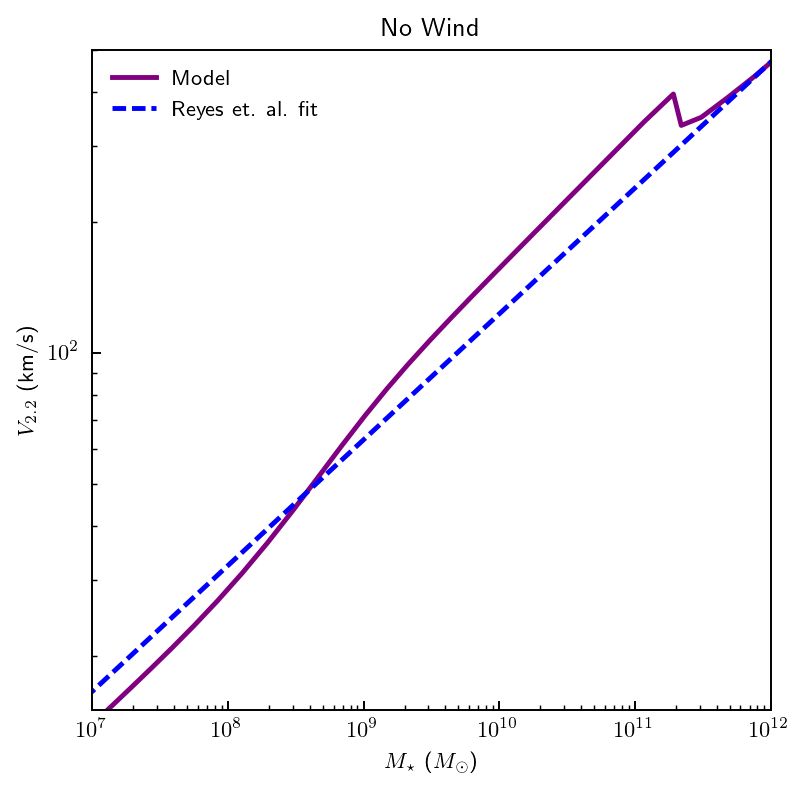

In [55]:
fig = plt.figure(figsize = (5,5))
plt.plot(MstelNO, V22NO, c ='purple', linewidth = 2, label=r'Model')
plt.plot(MstelNO, VreyesNO, c = 'b', ls = '--', linewidth = 2, label = r'Reyes et. al. fit')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e12)
plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$V_{2.2}$ ($\mbox{km/s}$)")
plt.title("No Wind")


plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()

### Second model: Winds, constant loading  factor $\eta = 1$

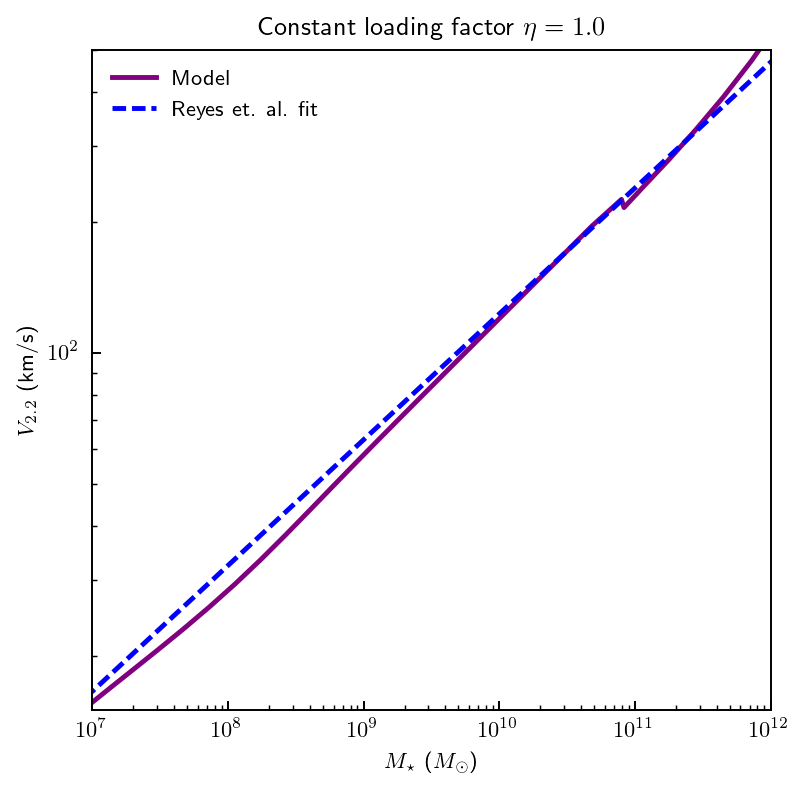

In [56]:
fig = plt.figure(figsize = (5,5))
plt.plot(MstelCON, V22CON, c ='purple', linewidth = 2, label=r'Model')
plt.plot(MstelCON, VreyesCON, c = 'b', ls = '--', linewidth = 2, label = r'Reyes et. al. fit')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e12)
plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$V_{2.2}$ ($\mbox{km/s}$)")
plt.title("Constant loading factor $\eta =1.0$")


plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()

### Third Model: Winds, Muratov et. al. 2015 model

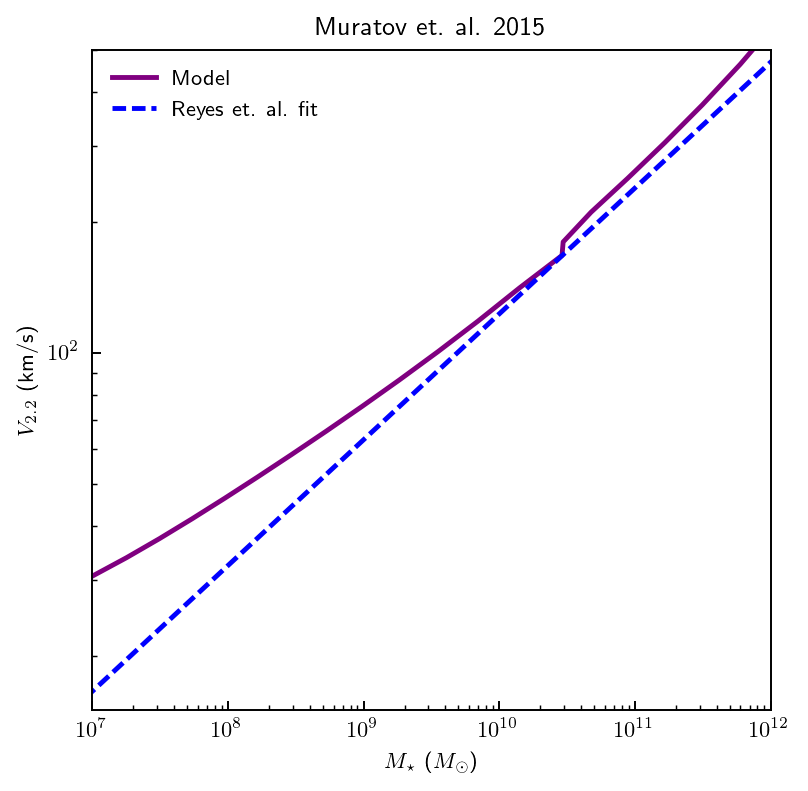

In [57]:
fig = plt.figure(figsize = (5,5))
plt.plot(MstelMUR, V22MUR, c ='purple', linewidth = 2, label=r'Model')
plt.plot(MstelMUR, VreyesMUR, c = 'b', ls = '--', linewidth = 2, label = r'Reyes et. al. fit')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e12)
plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$V_{2.2}$ ($\mbox{km/s}$)")
plt.title("Muratov et. al. 2015")


plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()

We see that our model predicts quite well the observed relation (best fit, Reyes et. al.). The best matching between the model and the observations happens when outflows are included, especially when we assume a constant loading factor $\eta = 1$.


### Part b) Comparison between BTFR and data from Bradford et al. (2016)


### First Model: No winds

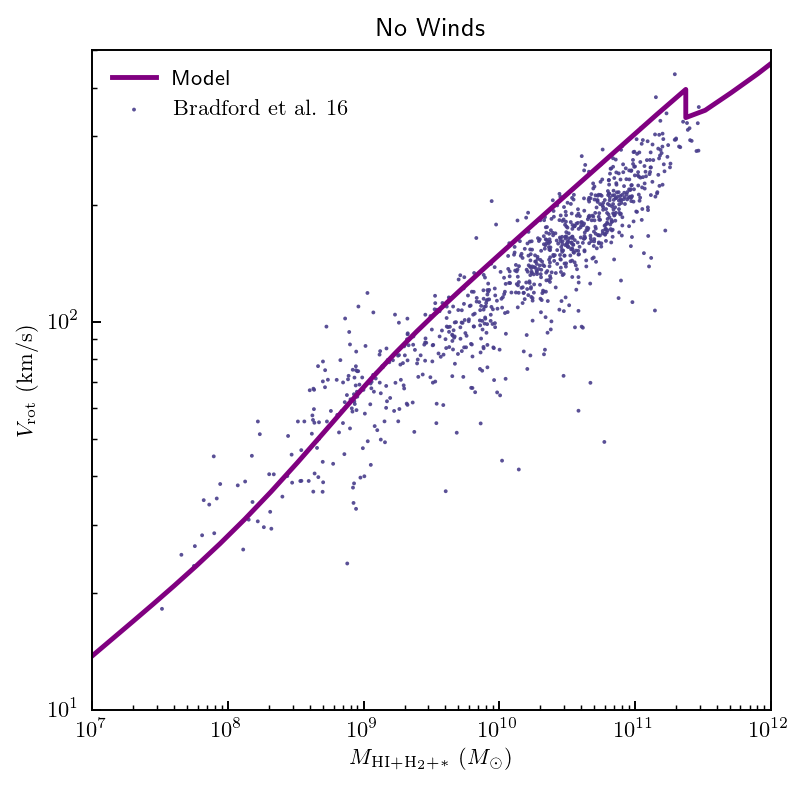

In [58]:
import pyfits
from code.setup import data_home_dir
from code.plot_utils import plot_pretty
from matplotlib import pylab as plt
plot_pretty()

bf1 = pyfits.open('figure_1_bradford_2016.fits')[1].data
# if you want to see what's in the fits table, uncomment
#bf1h = pyfits.open('data/figure_1_bradford_2016.fits')[1].header
#print bf1h

mbbar = bf1['MBARYON']; embar = bf1['MBARYON_ERR']
w20b = bf1['VW20I']; ew20b = bf1['VW20I_ERR']
#mbHI = np.log10(mbHI) + 0.1238; mbs = np.log10(mbs) + 9.0
mbbar += 0.1238 

plt.figure(figsize=(5.,5.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_{\rm HI+H_2+*}\ {(M_\odot)}$')
plt.scatter(10.**mbbar,w20b,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')
plt.plot(MstelNO+MgasNO, V22NO, c ='purple', linewidth = 2, label=r'Model')
plt.title("No Winds")

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

### Second model: Winds, constant loading  factor $\eta = 1$

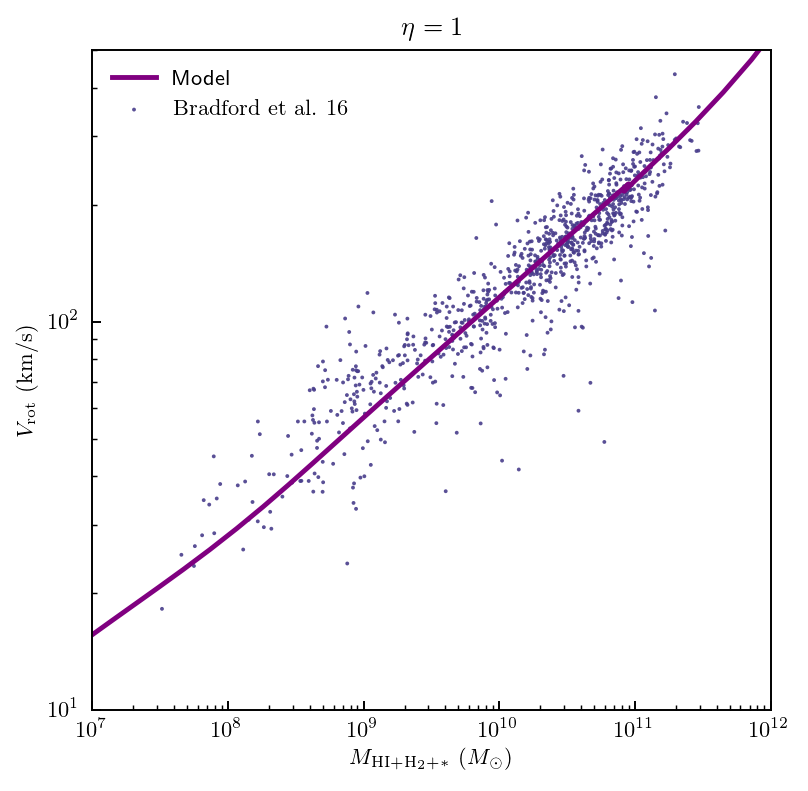

In [59]:
import pyfits
from code.setup import data_home_dir
from code.plot_utils import plot_pretty
from matplotlib import pylab as plt
plot_pretty()

bf1 = pyfits.open('figure_1_bradford_2016.fits')[1].data
# if you want to see what's in the fits table, uncomment
#bf1h = pyfits.open('data/figure_1_bradford_2016.fits')[1].header
#print bf1h

mbbar = bf1['MBARYON']; embar = bf1['MBARYON_ERR']
w20b = bf1['VW20I']; ew20b = bf1['VW20I_ERR']
#mbHI = np.log10(mbHI) + 0.1238; mbs = np.log10(mbs) + 9.0
mbbar += 0.1238 

plt.figure(figsize=(5.,5.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_{\rm HI+H_2+*}\ {(M_\odot)}$')
plt.scatter(10.**mbbar,w20b,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')
plt.plot(MstelCON+MgasCON, V22CON, c ='purple', linewidth = 2, label=r'Model')
plt.title("$\eta = 1$")

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

### Third Model: Winds, Muratov et al. 2015 model

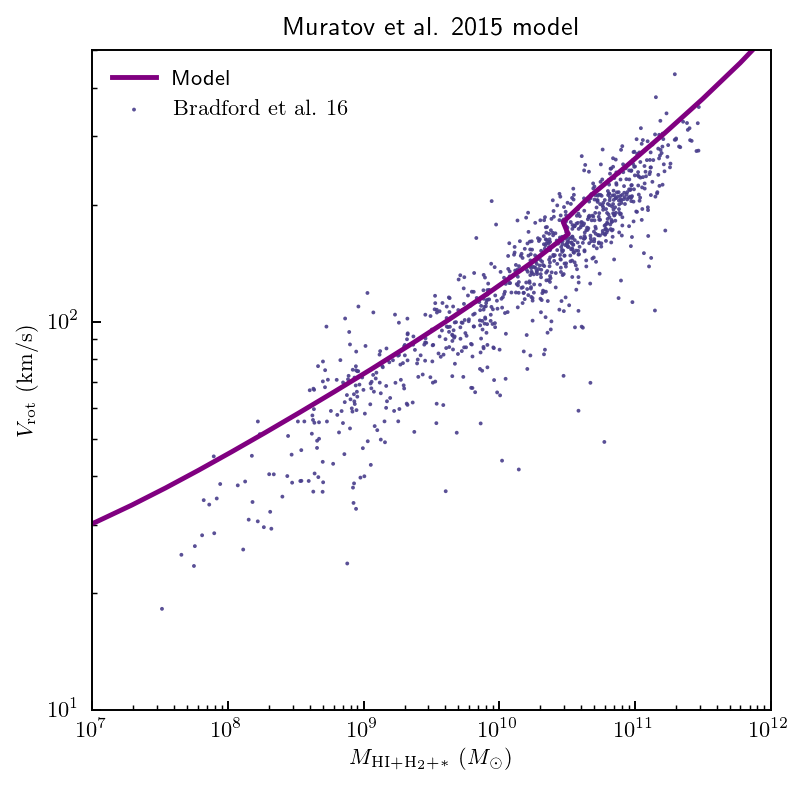

In [60]:
import pyfits
from code.setup import data_home_dir
from code.plot_utils import plot_pretty
from matplotlib import pylab as plt
plot_pretty()

bf1 = pyfits.open('figure_1_bradford_2016.fits')[1].data
# if you want to see what's in the fits table, uncomment
#bf1h = pyfits.open('data/figure_1_bradford_2016.fits')[1].header
#print bf1h

mbbar = bf1['MBARYON']; embar = bf1['MBARYON_ERR']
w20b = bf1['VW20I']; ew20b = bf1['VW20I_ERR']
#mbHI = np.log10(mbHI) + 0.1238; mbs = np.log10(mbs) + 9.0
mbbar += 0.1238 

plt.figure(figsize=(5.,5.))
plt.xscale('log'); plt.yscale('log')
plt.xlim([1.e7,1.e12]); plt.ylim([10.,500.])
plt.ylabel(r'$V_{\rm rot}\ \mathrm{(km/s)}$'); plt.xlabel(r'$M_{\rm HI+H_2+*}\ {(M_\odot)}$')
plt.scatter(10.**mbbar,w20b,marker='.',c='darkslateblue',s=10.,alpha=0.9,edgecolor='none', label=r'$\mathrm{Bradford\ et\ al.\ 16}$')
plt.plot((MstelMUR+MgasMUR), V22MUR, c ='purple', linewidth = 2, label=r'Model')
plt.title("Muratov et al. 2015 model")

plt.legend(frameon=False,loc='upper left', fontsize=9)
plt.show()

### Problem 4 -  Galactic outflows and effective yield

A useful concept, which emerges from simple chemical evolution models described in ex10 notebook, is the effective yield, $y_{\rm eff}$. It is defined as $$y_{\rm eff}=Z/\ln(1/f_{\rm gas}),$$ where $Z$ is the mass fraction of heavy elements in the gas and $f_{\rm gas}\equiv M_{\rm gas}/(M_{\rm gas}+M_*)$ is the gas mass fraction in the system. Read the chemical evolution model description in the second half of the ex10 notebook on how this quantity comes about and why it is related to chemical evolution models.
Briefly, if galaxy was a closed system, the effective yield would be driven to the true yield of a stellar population set as y_Z in the galaxy model (for a Chabrier IMF it is $y_{\rm Z}\approx 0.07$). However, in the presence of outflows, yield would be lower than the true yield. Thus, $y_{\rm eff}$ is a diagnostics that outflows operate in galaxies.

a) Plot $y_{\rm eff}$ as a function of $M_*$ for model without outflows, for model with outflows but constant $\epsilon_{\rm out}$, and with mass-dependent outflow metallicity of Muratov et al. (2015) or something close. How does effective yield of galaxies change in these models?

b) Estimate the fraction of metals retained within stars and gas of the galaxy. Plot the retained fraction as a function of galaxy stellar mass and compare with the observed trend discussed in for the model without wind and with the wind Peeples et al. (2014). How do you interpret the results in terms of the galaxy formation processes?


### Solution

### Part a) $y_{\rm eff}$


In [61]:
Nm = 60
lMh = np.linspace(5.0, 8., Nm)
Mh  = np.power(10, lMh)
z = 0.0

#Mass in heavy elements, model without winds

MZNO = 10.**lMZinw(np.log10(1.0+z),lMh)

#Mass in heavy elements, model with constant loading factor, eta = 1

MZCON = 10.**lMZiw1(np.log10(1.0+z),lMh)

#Mass in heavy elements, Muratov et al. 2015 Model

MZMUR = 10.**lMZiMw(np.log10(1.0+z),lMh)


Now, we will use the formula: 

\begin{equation}
y_{\rm eff} = \frac{Z}{\ln\left(\frac{1}{f_{\rm gas}}\right)},
\end{equation}

$Z = \frac{M_Z}{M_{\rm gas}}, \qquad f_{\rm gas} = \frac{M_{\rm gas}}{M_{\rm gas} + M_{\star}}$

in order to calculate $y_{\rm eff}$ in three different cases: no wind, constant wind $\eta =1$, and wind according to the model of Muratov et al.


### Model 1 - No winds 



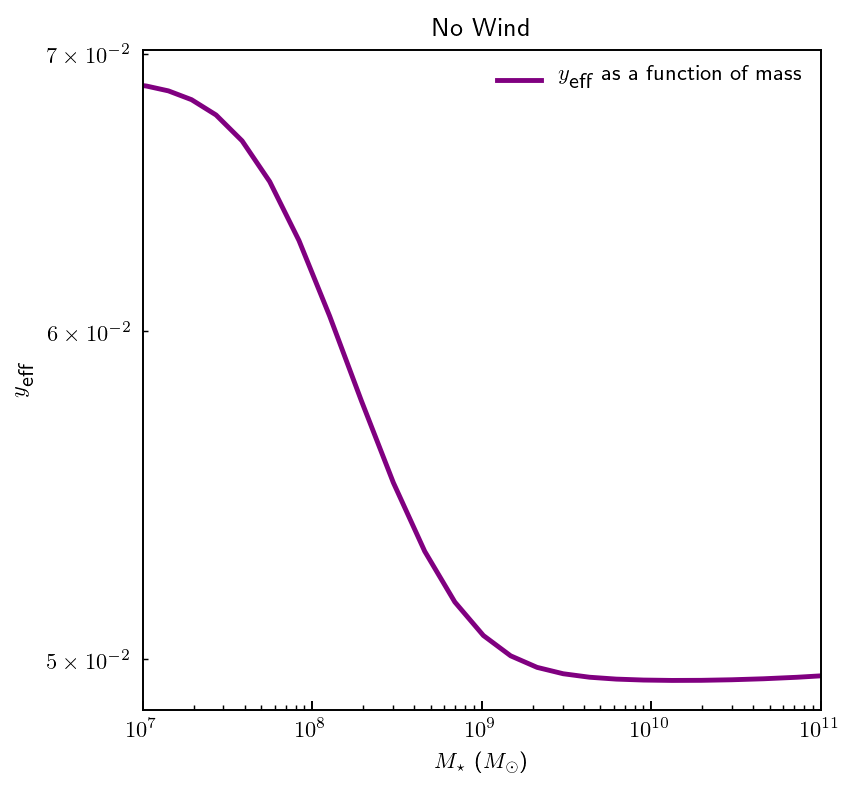

In [62]:
ZNO = MZNO/MgasNO
fgasNO = MgasNO/(MgasNO + MstelNO)
yeffNO = ZNO/(np.log(1.0/fgasNO))


fig = plt.figure(figsize = (5,5))
plt.plot(MstelNO, yeffNO, c ='purple', linewidth = 2, label=r'$y_{\mbox{eff}}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
#plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$y_{ \mbox{eff}}$")
plt.title("No Wind")


plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()




### Model 2 - Winds, constant loading factor $\eta = 1$

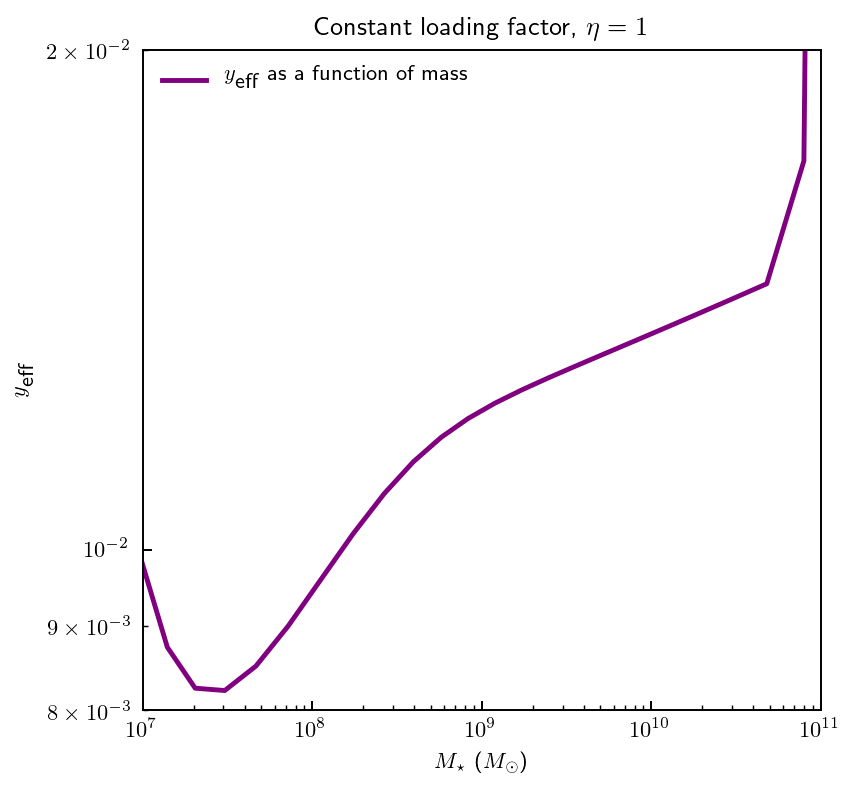

In [63]:
ZCON = MZCON/MgasCON
fgasCON = MgasCON/(MgasCON + MstelCON)
yeffCON = ZCON/(np.log(1.0/fgasCON))

fig = plt.figure(figsize = (5,5))
plt.plot(MstelCON, yeffCON, c ='purple', linewidth = 2, label=r'$y_{\mbox{eff}}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
plt.ylim(8e-3,2e-2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$y_{ \mbox{eff}}$")
plt.title("Constant loading factor, $\eta =1$")


plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()



### Model 3 - Winds, Muratov et al. 2015 model 

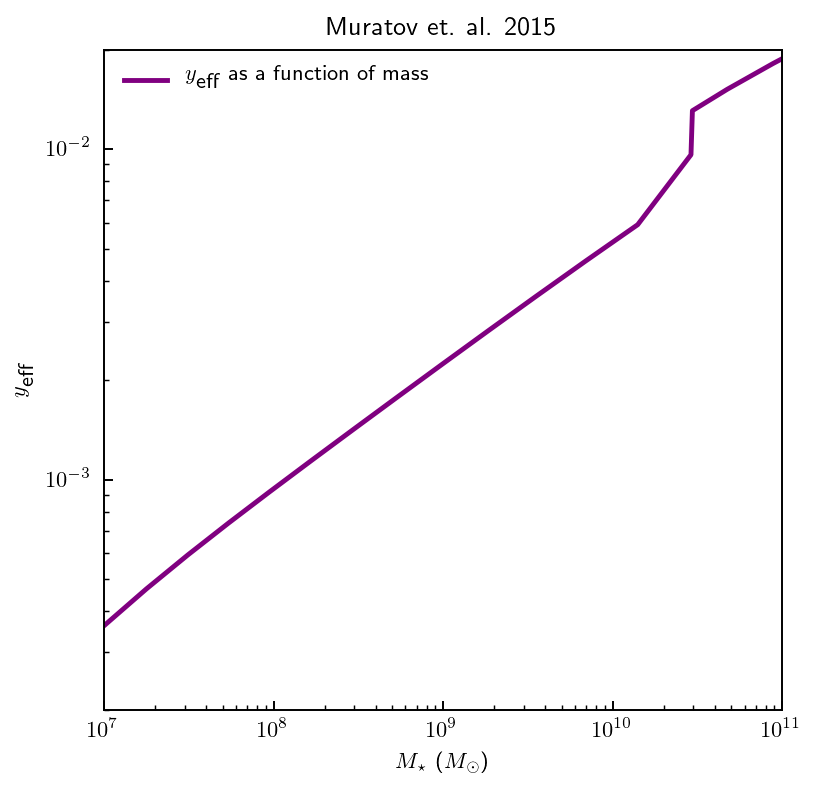

In [64]:
ZMUR = MZMUR/MgasMUR
fgasMUR = MgasMUR/(MgasMUR + MstelMUR)
yeffMUR = ZMUR/(np.log(1.0/fgasMUR))

fig = plt.figure(figsize = (5,5))
plt.plot(MstelMUR, yeffMUR, c ='purple', linewidth = 2, label=r'$y_{\mbox{eff}}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
plt.ylim(2e-4,2e-2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$y_{ \mbox{eff}}$")
plt.title("Muratov et. al. 2015")


plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()




TODO

### b) Retained fraction of metals


For this problem, I will follow two approaches in order to estimate the retained fraction of metals. First by comparing the metals in each of our models to the metals in the closed box model, and second using the formulae provided in the Peeples et al. model.

We want to estimate:

\begin{equation}
f_Z = \frac{M_Z}{M_{\rm Z, available}}
\end{equation}

We have M_Z; the difficult is to estimate $M_{\rm Z, available}$, which is the total metal mass ever produced (up to $z=0$). How do we estimate that? 

Let's suppose that is equal to the total metal mass predicted by the $\mathbf{closed\, box \,model}$; i.e. a model without inflows or outflows. Since there are no such processes, we can assume that the model predicts the total available mass (the total metal mass ever produced).

The prediction of the closed box model for the metalicity, $Z$, is: 

\begin{equation}
Z_{\rm closed} = y_Z \ln \left(\frac{1}{f_g} \right)
\end{equation}

Thus, the total mass in metals is: 

\begin{equation}
M_{\rm Z, closed} = M_g y_Z \ln \left(\frac{1}{f_g}\right)
\end{equation}

So, the retained fraction is:
\begin{equation}
f_Z = \frac{M_Z}{M_{\rm Z, closed}} = \frac{M_Z}{M_g y_Z \ln \left(\frac{1}{f_g} \right)} = \frac{y_{\rm eff}}{y_Z} \qquad (\star)
\end{equation}


We can say that $y_Z = 0.07 =$const.  and thus $f_z \propto y_{eff}$.


Peeples et al. provide another recipe in order to calculate $M_{Z, available}$. We will calculate both and we'll compare.
Assuming that most metals come from supernovae (type Ia and II), we can write: 

\begin{equation}
M_{\rm Z, available} = M_{\rm Z, Ia} + M_{\rm Z, II}
\end{equation}

Fitting formulae for $ M_{\rm Z, Ia}$ and  $M_{\rm Z, II}$:

\begin{equation}
M_{\rm Z, Ia} = 1.043\log\left(\frac{M_{\star}}{M_\odot} \right)  - 2.683 \qquad (\star \star)
\end{equation}

and

\begin{equation}
M_{\rm Z, II} = 1.0146\log\left(\frac{M_{\star}}{M_\odot} \right)  + \log y_{II} + 0.1091 \qquad (\star \star \star)
\end{equation}

with $y_{II} \cong 0.030$.

I will calculate all models, $(\star)$ and those that use the combination of $(\star \star)$ and $(\star \star \star)$.


It is straighforward (since we have the results for $y_{eff}$)  to plot the results for the first model/ estimation of $f_Z$ for the three wind models we have considered so far. 

### Model 1 - No winds

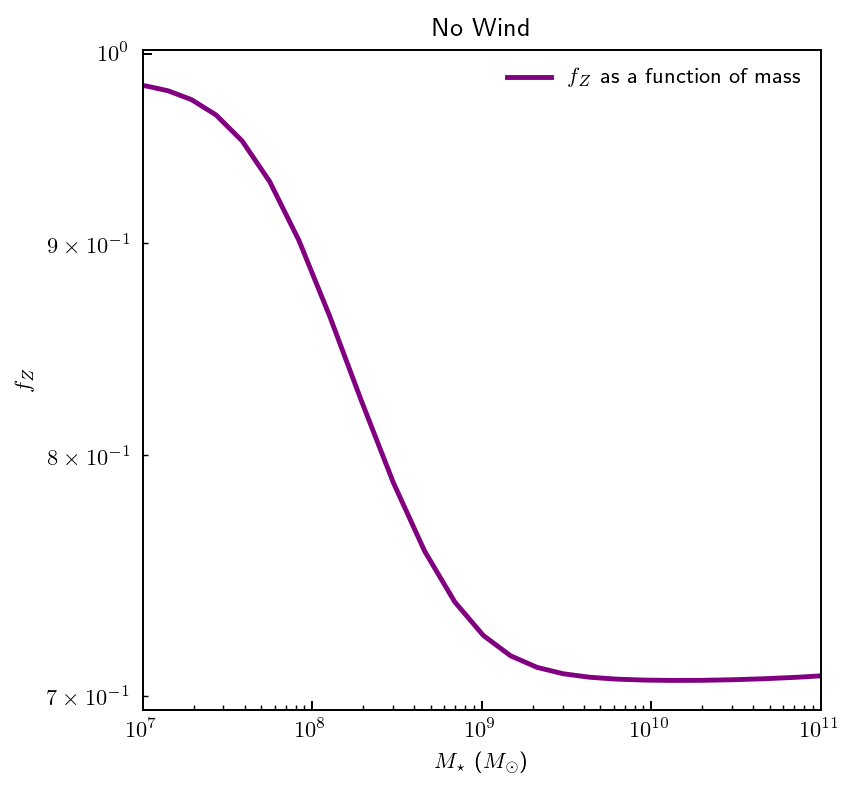

In [65]:
fig = plt.figure(figsize = (5,5))
plt.plot(MstelNO, yeffNO/0.07, c ='purple', linewidth = 2, label=r'$f_{Z}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
#plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$f_{Z}$")
plt.title("No Wind")

plt.legend(frameon=False, loc='upper right', fontsize=9)
plt.show()


### Model 2 - Constant loading factor $\eta = 1$.

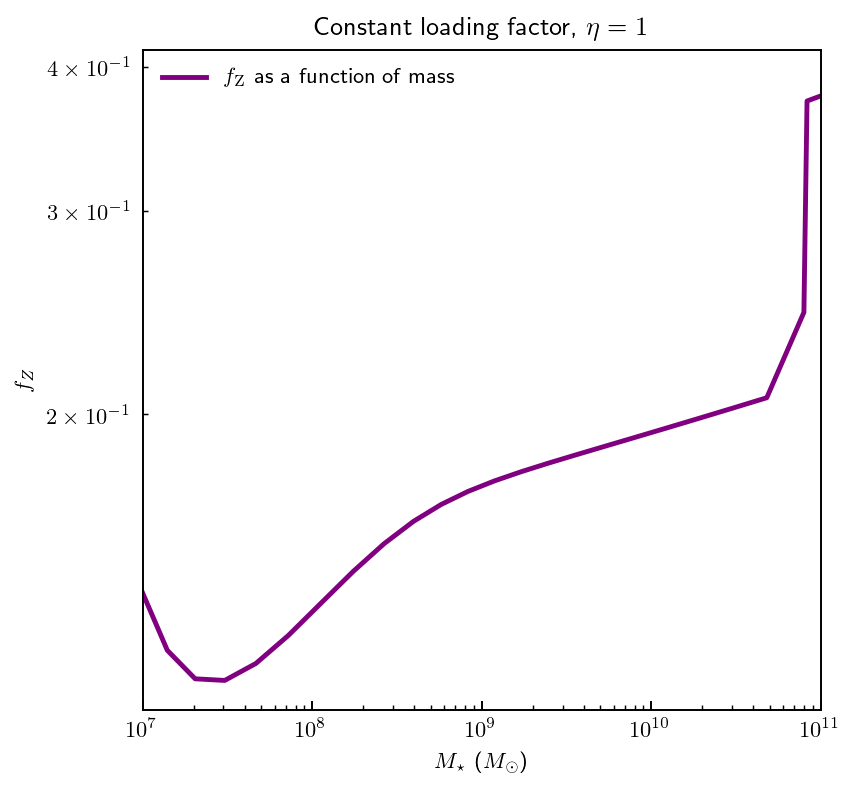

In [66]:
fig = plt.figure(figsize = (5,5))
plt.plot(MstelCON, yeffCON/0.07, c ='purple', linewidth = 2, label=r'$f_{\rm Z}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
#plt.ylim(8e-3,2e-2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$f_Z$")
plt.title("Constant loading factor, $\eta =1$")

plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()




### Model 3 - Muratov et al. 2015

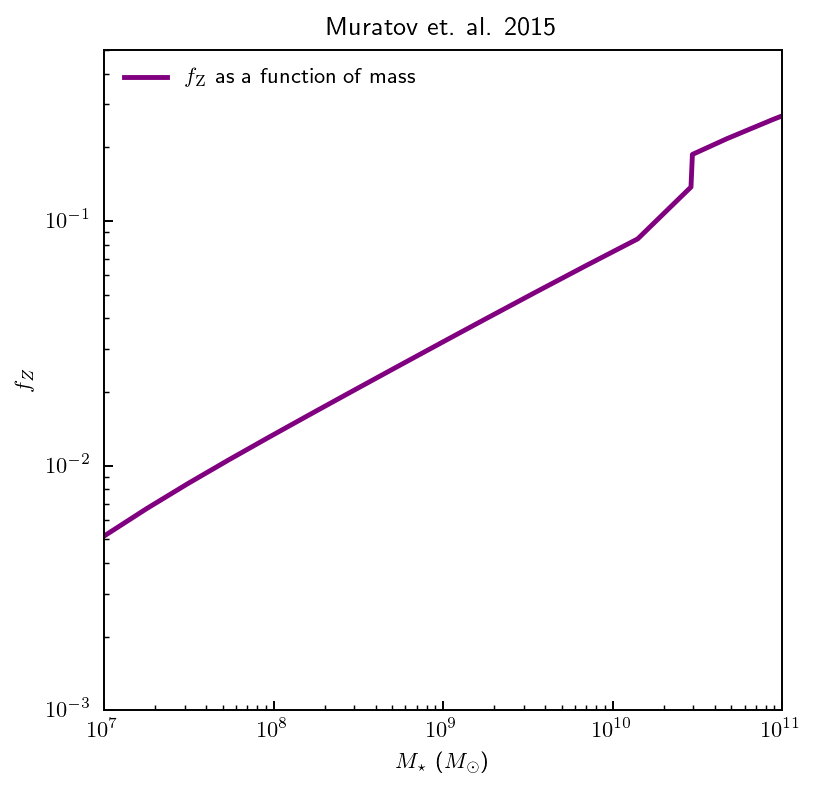

In [67]:

fig = plt.figure(figsize = (5,5))
plt.plot(MstelMUR, yeffMUR/0.07, c ='purple', linewidth = 2, label=r'$f_{\rm Z}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
plt.ylim(1e-3,5e-1)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$f_{ Z}$")
plt.title("Muratov et. al. 2015")


plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()



Now, for each of these model, let's use the formulae of Peeples et al. to calculate $M_{Z, available}$ and thus $f_Z$.

### Model 1 - No winds

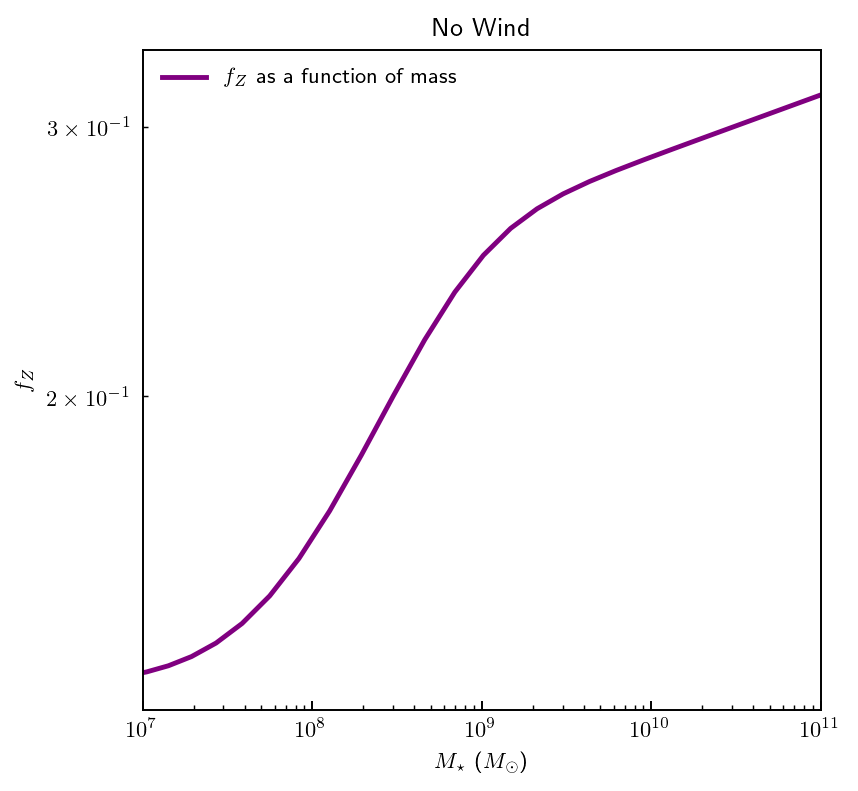

In [68]:
# First calculate total available mass in metals

yii = 0.030

MavailNO = np.power(10,0.1091+np.log10(yii))*(MstelNO**1.0146) + np.power(10,-2.683)*(MstelNO**1.043)

#Calculate retained fraction

fZNO = MZNO/MavailNO

#Plot 

fig = plt.figure(figsize = (5,5))
plt.plot(MstelNO, fZNO, c ='purple', linewidth = 2, label=r'$f_{Z}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
#plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$f_{Z}$")
plt.title("No Wind")

plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()



### Model 2 - Constant Winds, $\eta = 1$

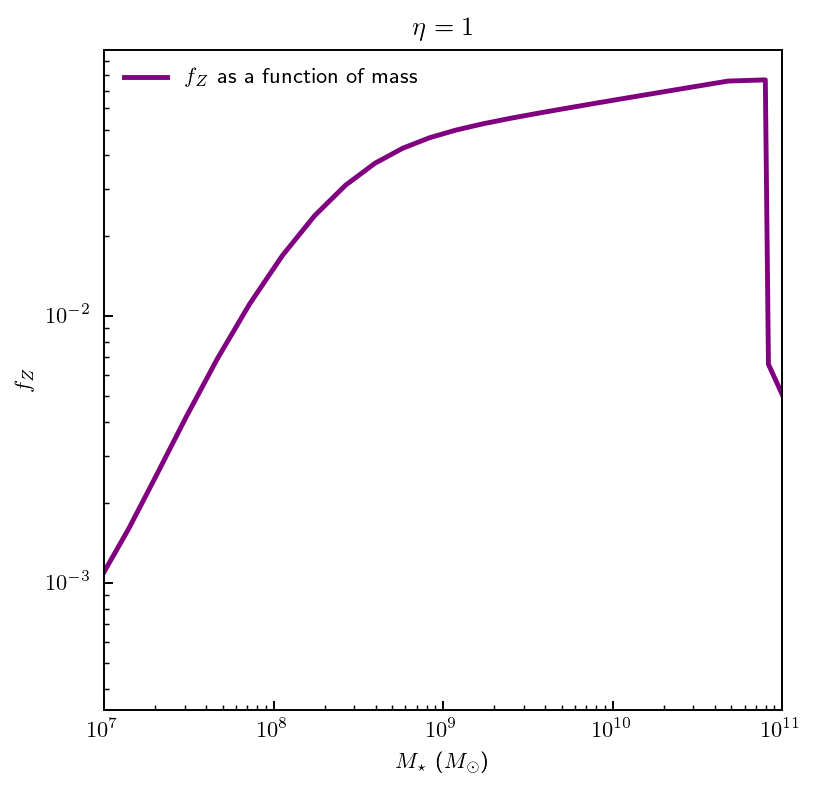

In [69]:
# First calculate total available mass in metals

yii = 0.030

MavailCON = np.power(10,0.1091+np.log10(yii))*(MstelCON**1.0146) + np.power(10,-2.683)*(MstelCON**1.043)

#Calculate retained fraction

fZCON = MZCON/MavailCON

#Plot 

fig = plt.figure(figsize = (5,5))
plt.plot(MstelCON, fZCON, c ='purple', linewidth = 2, label=r'$f_{Z}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
#plt.ylim(1.5e1,5e2)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$f_{Z}$")
plt.title("$\eta =1$")

plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()



### Model 3 - Muratov et al. 2015 

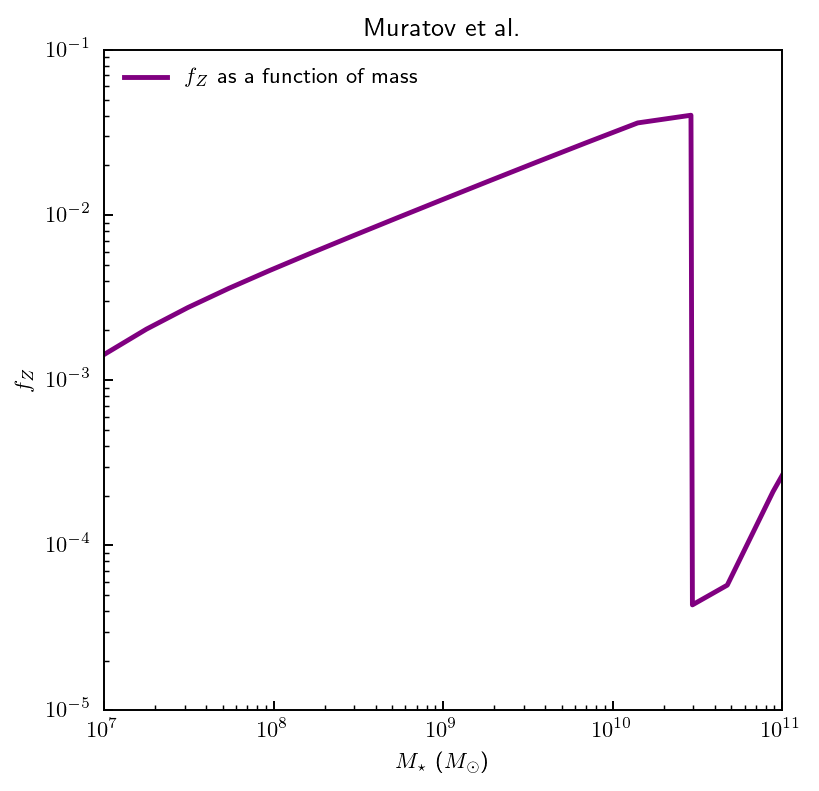

In [70]:
# First calculate total available mass in metals

yii = 0.030

MavailMUR = np.power(10,0.1091+np.log10(yii))*(MstelMUR**1.0146) + np.power(10,-2.683)*(MstelMUR**1.043)

#Calculate retained fraction

fZMUR = MZMUR/MavailMUR

#Plot 

fig = plt.figure(figsize = (5,5))
plt.plot(MstelMUR, fZMUR, c ='purple', linewidth = 2, label=r'$f_{Z}$ as a function of mass')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e7,1e11)
plt.ylim(1e-5,1e-1)
plt.xlabel("$M_\star$ ($M_\odot$)")
plt.ylabel("$f_{Z}$")
plt.title("Muratov et al.")

plt.legend(frameon=False, loc='upper left', fontsize=9)
plt.show()

We see that we have completely different results in the two cases.  

I believe that the closed box model (the procedure that led to equation ($\star$) ) is too simplistic to give the available metal mass.

